<a href="https://colab.research.google.com/github/itterate/Speech-emotion-recognition/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract

Speech emotion recognition is the perspective field of study that can be helpful in various industries. For example, it can used for digital avatars where the  AI can determine the tone and emotions of the user’s voice for further generation messages. The study explores speech emotion recognition using CNN (1-dimensional Convolutional Neural Network) and Facebook transformer which pre-trained from 960 hours of audio. As a main dataset, CREMA-D was used in the project containing about 7200 samples where several voice actors repeated phrases with different intonations, the target values are happy, sad, fear, neutral, anger, and disgust. To extract information from wav type audio file, I used librosa library and implemented data augmentation in the training dataset by adding noise, fetching, and stretching the audio. The data was sliced into training, validation, and test data with the ratio 7:1,5:1,5 respectively. For fine-tuning the best hyperparameters for CNN optuna were implemented and the results get 3 layers with 256, 128, and 64 filter numbers for each layer. Overall, the transformer model outperformed the CNN model with an accuracy score of 60% and 40% respectively.

In [ ]:
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor, Wav2Vec2Model, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import librosa
import librosa.display
import torch
import torchaudio
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
!pip install optuna
import optuna
import os
import librosa.display
from IPython.display import Audio
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Dense, Flatten, GlobalAveragePooling1D

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00


In [ ]:
np.random.seed(42)

# Data preprocessing

In [ ]:
# You can also load the dataset from the Kaggle
# import kagglehub

# # Download dataset
# path = kagglehub.dataset_download("ejlok1/cremad")

# print("Path to dataset files:", path)

100%|██████████| 451M/451M [00:21<00:00, 21.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ejlok1/cremad/versions/1


In [ ]:
import os

# Directory containing audio files
crema_directory = "/content/drive/MyDrive/Colab Notebooks/Crema/"

# Initialize lists
file_path = []
file_emotion = []

# Get all files in the directory
crema_directory_list = os.listdir(crema_directory)

# Map filenames to labels
for i in crema_directory_list:
    file_path_temp = os.path.join(crema_directory, i)
    file_path.append(file_path_temp)  # Append full file path

    # Extract emotion from filename
    splitted_data = i.split("_")
    if splitted_data[2] == "SAD":
        file_emotion.append("sad")
    elif splitted_data[2] == "DIS":
        file_emotion.append("disgust")
    elif splitted_data[2] == "HAP":
        file_emotion.append("happy")
    elif splitted_data[2] == "FEA":
        file_emotion.append("fear")
    elif splitted_data[2] == "NEU":
        file_emotion.append("neutral")
    elif splitted_data[2] == "ANG":
        file_emotion.append("angry")
    else:
        file_emotion.append("unknown")  # For unexpected cases


In [ ]:
emotion_df = pd.DataFrame(file_emotion, columns =["Emotions"])
file_df = pd.DataFrame(file_path, columns = ["file_path"])
df = pd.concat([file_df,emotion_df ], axis = 1)
df

,file_path,Emotions
0,/content/drive/MyDrive/Colab Notebooks/Crema/1...,disgust
1,/content/drive/MyDrive/Colab Notebooks/Crema/1...,fear
2,/content/drive/MyDrive/Colab Notebooks/Crema/1...,neutral
3,/content/drive/MyDrive/Colab Notebooks/Crema/1...,happy
4,/content/drive/MyDrive/Colab Notebooks/Crema/1...,happy
...,...,...
7437,/content/drive/MyDrive/Colab Notebooks/Crema/1...,disgust
7438,/content/drive/MyDrive/Colab Notebooks/Crema/1...,happy
7439,/content/drive/MyDrive/Colab Notebooks/Crema/1...,happy
7440,/content/drive/MyDrive/Colab Notebooks/Crema/1...,angry


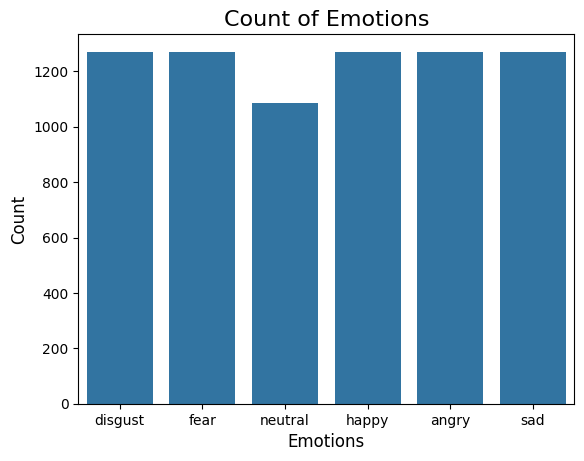

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(x="Emotions", data=df)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.show()

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    ax = plt.gca()  # Get the current axis
    librosa.display.waveshow(data, sr=sr, ax=ax)
    plt.show()



def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
#     librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

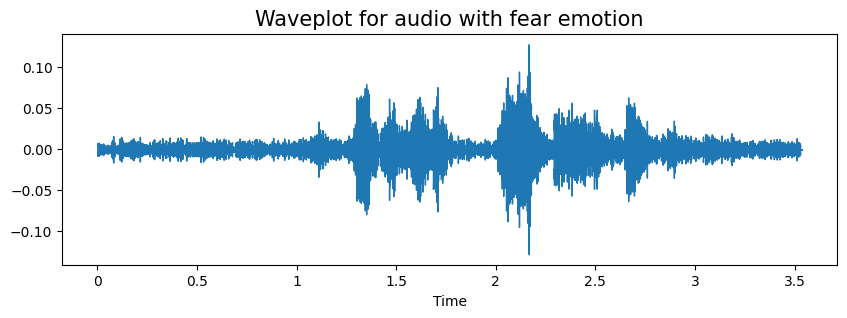

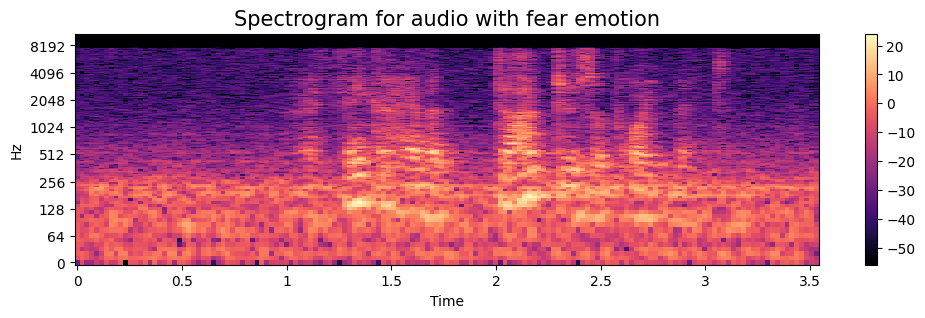

In [ ]:
emotion = 'fear'
path = np.array(df.file_path[df.Emotions == emotion])[1]
data, sampling_rate = librosa.load(path)

create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)

Audio(data=data, rate=sampling_rate)


# Feature Extraction for CNN



In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)


def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)



In [ ]:
def extract_features(data,sample_rate):

    result = np.array([])

    # ZCR measures how often the signal changes sign (crosses zero) within a frame.
    # It helps to identify noisiness or tonal properties of the audio
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr))

    # Chroma features represent the energy distribution over the 12 pitch classes (notes like C, C#, D, etc.).
    # Useful for analyzing harmonic content and tonal characteristics.
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))

    # MFCCs are compact representations of the spectral envelope and are commonly used in speech processing.
    # They model how humans perceive sound and are effective for identifying characteristics of the audio.
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))

    # RMS measures the average loudness (energy) of the audio over time.
    # It is useful for detecting the dynamic range and overall intensity of the audio signal.
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))

    # The Mel Spectrogram converts the audio signal into a visual representation of energy across frequency bands.
    # It uses the Mel scale, which mimics human auditory perception.
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))

    return result



In [ ]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5)

    # without augmentation
    res1 = extract_features(data,sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data,sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result


In [ ]:
# Used fot the val_test dataset, without augementation
def get_features_test(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0)
    res1 = extract_features(data, sample_rate)
    return res1

In [ ]:
X_temp = df.file_path.copy()
y_temp = df.Emotions.copy()
X_train, X_val_test, y_train, y_val_test = train_test_split(X_temp,y_temp, test_size=0.3, random_state=42, shuffle = True)

In [ ]:
# The feature extraction from dataset is quite expensive, I loaded also augemented and feature extracted data for the val_test and train dataset.
X_train_aug = []
y_train_aug = []


for path, emotion in zip(X_train,y_train):
    feature = get_features(path)
    for el in feature:
        X_train_aug.append(el)
        y_train_aug.append(emotion)

In [ ]:
# For the convinience I loaded data to not spending the time
Features_train = pd.DataFrame(X_train_aug)
Features_train['labels'] = y_train_aug
Features_train.to_csv('features_train1.2.csv', index=False)
Features_train.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.066848,0.487592,0.605792,0.541631,0.487148,0.471681,0.514263,0.486501,0.518324,0.611852,...,1.087317e-08,1.016951e-08,9.665749e-09,9.287922e-09,9.005802e-09,8.804019e-09,8.657482e-09,8.564087e-09,8.505341e-09,fear
1,0.269847,0.633093,0.711385,0.721874,0.702609,0.677617,0.663506,0.586928,0.617541,0.694385,...,1.353950e-02,1.361020e-02,1.455958e-02,1.381275e-02,1.297793e-02,1.352956e-02,1.343071e-02,1.338843e-02,1.360604e-02,fear
2,0.076364,0.429496,0.583021,0.557335,0.508835,0.415483,0.452505,0.487067,0.469202,0.538415,...,8.556660e-09,7.612052e-09,6.959793e-09,6.469230e-09,6.126545e-09,5.875012e-09,5.728585e-09,4.578757e-09,1.775012e-09,fear
3,0.045017,0.575059,0.679728,0.641080,0.610431,0.639903,0.604407,0.569254,0.632249,0.678139,...,1.797904e-08,1.677191e-08,1.591052e-08,1.526614e-08,1.478563e-08,1.444150e-08,1.419176e-08,1.403158e-08,1.393173e-08,happy
4,0.254602,0.750482,0.798352,0.819909,0.801594,0.812291,0.780058,0.661509,0.715722,0.746973,...,3.668568e-03,3.689777e-03,3.673791e-03,4.294163e-03,4.200879e-03,4.018085e-03,4.020665e-03,4.114050e-03,3.980314e-03,happy


In [ ]:
X_test_val_f = []
y_test_val_f = []

for path, emotion in zip(X_val_test, y_val_test):
    feature = get_features_test(path)
    X_test_val_f.append(feature)
    y_test_val_f.append(emotion)

KeyboardInterrupt: 

In [ ]:
Features_val_test = pd.DataFrame(X_test_val_f)
Features_val_test['labels'] = y_test_val_f
Features_val_test.to_csv('features_test_val1.2.csv', index=False)
Features_val_test.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.056654,0.620149,0.644266,0.649795,0.639955,0.696089,0.693811,0.695277,0.725035,0.797843,...,1.082037e-08,9.906581e-09,9.261100e-09,8.782373e-09,8.426086e-09,8.168403e-09,7.980965e-09,7.858310e-09,7.782824e-09,disgust
1,0.085656,0.600263,0.612243,0.526206,0.536099,0.642142,0.604881,0.693874,0.659721,0.573657,...,1.021518e-11,8.468769e-12,7.332407e-12,6.540347e-12,5.970854e-12,5.561105e-12,5.283638e-12,5.103477e-12,4.958185e-12,disgust
2,0.068379,0.646156,0.602525,0.627409,0.561311,0.561567,0.573769,0.645187,0.672160,0.598017,...,1.153134e-09,1.075780e-09,1.020899e-09,9.800900e-10,9.498501e-10,9.283044e-10,9.127805e-10,9.028737e-10,8.967133e-10,happy
3,0.057274,0.581044,0.604272,0.585503,0.624963,0.600010,0.573577,0.640776,0.698272,0.705908,...,3.665002e-10,3.409733e-10,3.215529e-10,3.062981e-10,2.944629e-10,2.856434e-10,2.790639e-10,2.746809e-10,2.719499e-10,angry
4,0.056681,0.558542,0.560609,0.592016,0.693767,0.686327,0.670945,0.782226,0.723835,0.709384,...,3.192934e-08,2.894308e-08,2.675088e-08,2.506290e-08,2.375764e-08,2.277183e-08,2.203002e-08,2.152385e-08,2.121092e-08,disgust


#CNN building

In [ ]:
df_val_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/features_test_val1.2.csv')
df_train = pd.read_csv("/content/features_train1.2.csv")

In [ ]:
y_train = df_train.labels
X_train = df_train.drop("labels",axis = 1)

y_val_test = df_val_test.labels
X_val_test = df_val_test.drop("labels",axis = 1)

In [ ]:
X_val,X_test,y_val,y_test = train_test_split(X_val_test,y_val_test,test_size=0.5,random_state=42)

In [ ]:
encoder = OneHotEncoder()
y_train_hot = encoder.fit_transform(y_train.values.reshape(-1, 1)).toarray()
y_val_hot = encoder.transform(y_val.values.reshape(-1, 1)).toarray()
y_test_hot = encoder.transform(y_test.values.reshape(-1, 1)).toarray()
print(f"y_train_hot.shape: {y_train_hot.shape}")
print(f"y_val_hot.shape: {y_val_hot.shape}")



y_train_hot.shape: (15627, 6)
y_val_hot.shape: (1116, 6)


In [ ]:
# scaled all my features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:

import optuna
import tensorflow as tf
from tensorflow.keras import layers, models

def objective(trial):
    # Hyperparameters to be tuned
    conv_layers = trial.suggest_int("conv_layers", 4, 6)
    filter_size = trial.suggest_categorical("filter_size", [32, 64, 128, 256])
    kernel_size = trial.suggest_categorical("kernel_size", [3, 5])
    dense_units = trial.suggest_int("dense_units", 32, 128, step=32)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    # Build the CNN model
    model = models.Sequential()

    # Add Conv1D layers
    for _ in range(conv_layers):
        model.add(layers.Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
        model.add(layers.MaxPooling1D(pool_size=2, strides = 1, padding = 'same'))


    # Flatten and add Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(units=dense_units, activation='relu'))
    model.add(layers.Dropout(rate=dropout_rate))
    model.add(layers.Dense(units=len(set(y)), activation='softmax'))

    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


    # Train the model
    history = model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_data=(X_val_scaled, y_val), verbose=0)
    val_accuracy = history.history['val_accuracy'][-1]

    return val_accuracy


In [ ]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # Run 15 trials, you can increase this for more thorough tuning

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best validation accuracy:", study.best_value)


In [ ]:
model = Sequential([
    Conv1D(256, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(64, kernel_size=3, activation='relu'),
    GlobalAveragePooling1D(),

    Dense(128, activation='relu', kernel_regularizer='l2'),
    Dropout(0.4),

    Dense(6, activation='softmax')
])
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 160, 256)            │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 80, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 80, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 78, 128)             │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 39, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 39, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 37, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 133,190 (520.27 KB)

 Trainable params: 133,190 (520.27 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(X_train_scaled, y_train_hot, batch_size=64, epochs=50, validation_data=(X_val_scaled, y_val_hot), callbacks=[rlrp])



Epoch 1/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.2556 - loss: 2.1210 - val_accuracy: 0.3333 - val_loss: 1.5949 - learning_rate: 0.0010
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.3314 - loss: 1.6047 - val_accuracy: 0.3477 - val_loss: 1.5492 - learning_rate: 0.0010
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3510 - loss: 1.5628 - val_accuracy: 0.3620 - val_loss: 1.5102 - learning_rate: 0.0010
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3555 - loss: 1.5475 - val_accuracy: 0.3629 - val_loss: 1.4995 - learning_rate: 0.0010
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3575 - loss: 1.5333 - val_accuracy: 0.3629 - val_loss: 1.4976 - learning_rate: 0.0010
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.3560 - loss: 1.5301 - val_accuracy: 0.3620 - val_loss: 1.4927 - learning_rate: 0.0010
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3531 - loss: 1.5437

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4385 - loss: 1.3784
Accuracy of our model on test data :  42.473119497299194 %


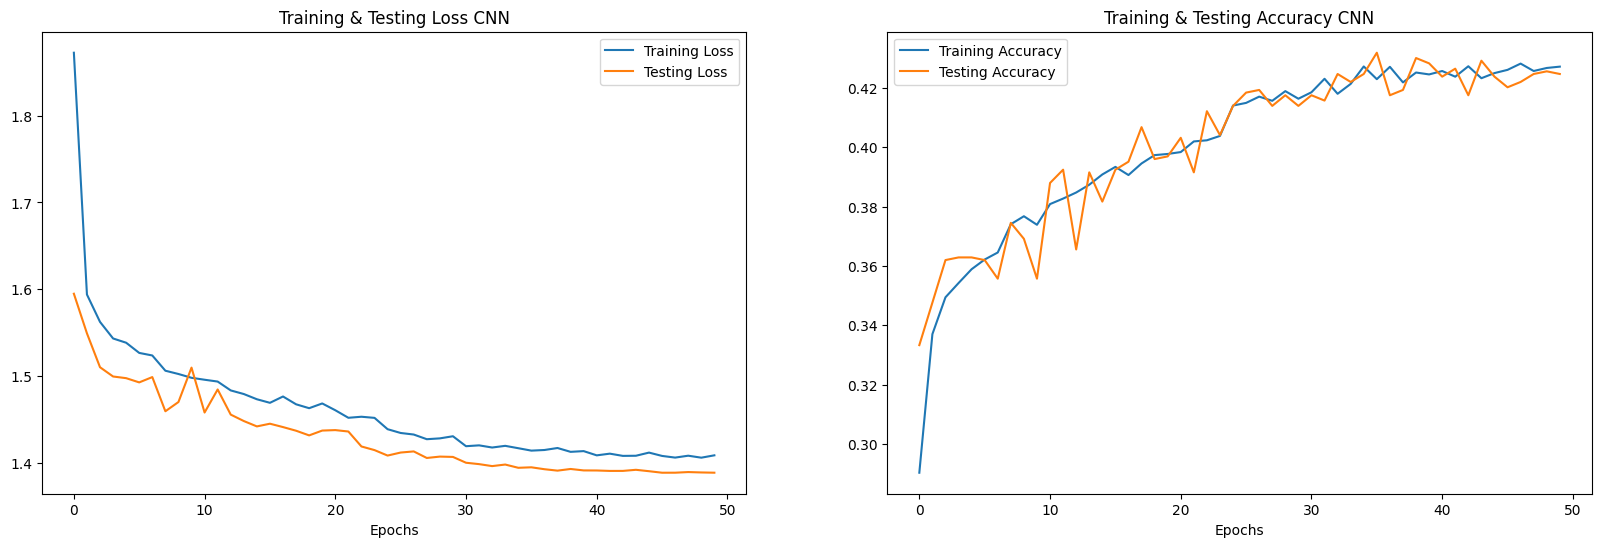

In [ ]:
import matplotlib.pyplot as plt
print("Accuracy of our model on test data : " , model.evaluate(X_val_scaled,y_val_hot)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss CNN')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy CNN')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
y_pred = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test_hot, axis=1)
print(classification_report(y_test, y_pred))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
              precision    recall  f1-score   support

           0       0.57      0.73      0.64       186
           1       0.34      0.08      0.13       194
           2       0.45      0.17      0.25       190
           3       0.32      0.36      0.34       193
           4       0.35      0.51      0.41       171
           5       0.43      0.69      0.53       183

    accuracy                           0.42      1117
   macro avg       0.41      0.42      0.38      1117
weighted avg       0.41      0.42      0.38      1117



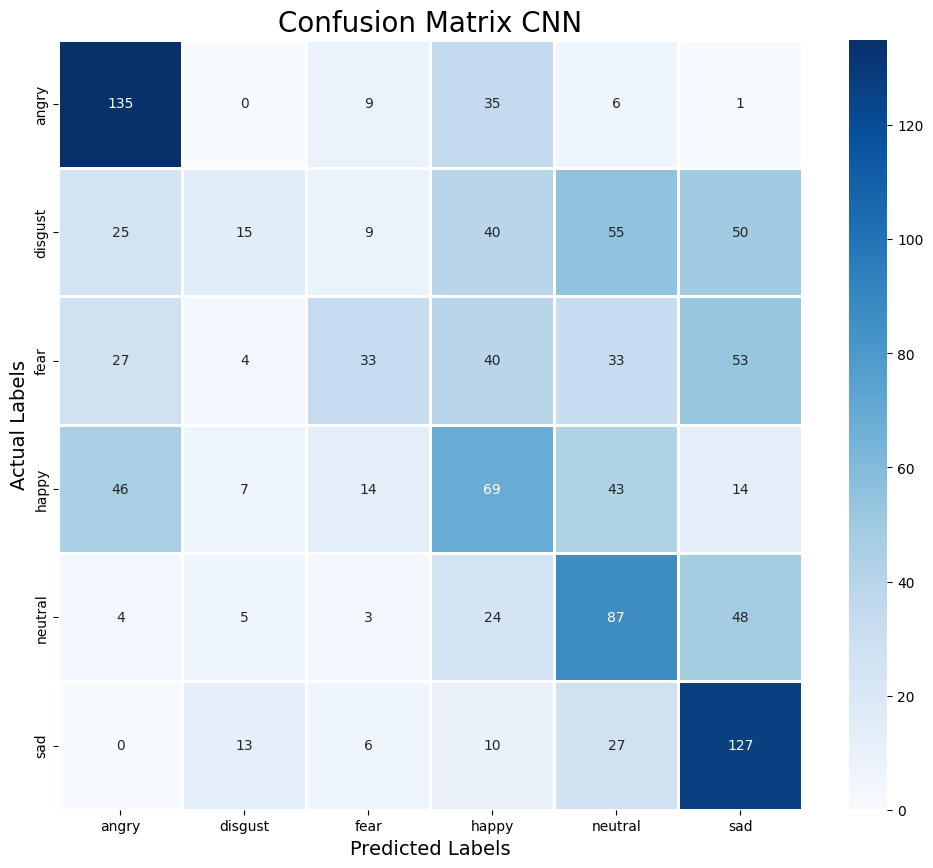

In [ ]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix CNN', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Wav2Vec

In [ ]:
class SpeechEmotionDataset(Dataset):
  def __init__(self,df,processor,max_length=32000):
    self.df = df
    self.processor = processor
    self.max_length = max_length

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    audio_path = self.df.iloc[idx]["file_path"]
    label = self.df.iloc[idx]["Emotions"]


    #loaded the AW file
    speech, sr = librosa.load(audio_path, sr=16000)



    # shorten or increase length of file
    if len(speech) > self.max_length:
      speech = speech[:self.max_length]
    else:
      speech = np.pad(speech, (0, self.max_length - len(speech)), mode='constant')

    inputs = self.processor(speech, sampling_rate=16000, return_tensors="pt", truncate = True, max_length =self.max_length)

    input_values = inputs.input_values.squeeze(0)

    return {"input_values":input_values,"labels": torch.tensor(label,dtype = torch.long)}



In [ ]:
label_map = {label: idx for idx,label in enumerate(df.Emotions.unique() )}
inverse_label_map = {v: k for k, v in label_map.items()}
df_trans = df.copy()
df_trans["Emotions"] = df_trans.Emotions.map(label_map)
df_trans

,file_path,Emotions
0,/content/drive/MyDrive/Colab Notebooks/Crema/1...,0
1,/content/drive/MyDrive/Colab Notebooks/Crema/1...,1
2,/content/drive/MyDrive/Colab Notebooks/Crema/1...,2
3,/content/drive/MyDrive/Colab Notebooks/Crema/1...,3
4,/content/drive/MyDrive/Colab Notebooks/Crema/1...,3
...,...,...
7437,/content/drive/MyDrive/Colab Notebooks/Crema/1...,0
7438,/content/drive/MyDrive/Colab Notebooks/Crema/1...,3
7439,/content/drive/MyDrive/Colab Notebooks/Crema/1...,3
7440,/content/drive/MyDrive/Colab Notebooks/Crema/1...,4


In [ ]:
train_df, test_val_df = train_test_split(df_trans, test_size=0.3, random_state=42,shuffle = True)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=42,shuffle = True)

In [ ]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
train_dataset = SpeechEmotionDataset(train_df,processor)
test_dataset = SpeechEmotionDataset(test_df,processor)
val_dataset = SpeechEmotionDataset(val_df,processor)

In [ ]:
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=6)

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate = 2e-5,
    report_to = []
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds, average='macro')
    rec = recall_score(labels, preds, average='macro')


    return {'accuracy': acc, 'precision': prec, 'recall': rec}

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics = compute_metrics
)
trainer.train()

Step,Training Loss
10,1.766900
20,1.776300
30,1.767700
40,1.738400
50,1.767900
60,1.694900
70,1.733400
80,1.702300
90,1.698800
100,1.631400


TrainOutput(global_step=3260, training_loss=1.2565061665751451, metrics={'train_runtime': 1745.1084, 'train_samples_per_second': 29.849, 'train_steps_per_second': 1.868, 'total_flos': 9.4582222975104e+17, 'train_loss': 1.2565061665751451, 'epoch': 10.0})

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 1.2003891468048096, 'eval_accuracy': 0.5666965085049239, 'eval_precision': 0.563106210465518, 'eval_recall': 0.5755168291996274, 'eval_runtime': 590.4839, 'eval_samples_per_second': 1.892, 'eval_steps_per_second': 0.237, 'epoch': 10.0}


In [ ]:
# Initialize lists to store true labels and predictions
true_labels = []
predicted_labels = []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation for evaluation
with torch.no_grad():
    for i in range(len(test_dataset)):
        # Get input values and label from the dataset
        input_values = test_dataset[i]['input_values'].unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
        true_label = int(test_dataset[i]['labels'])

        # Get model predictions
        outputs = model(input_values)
        logits = outputs.logits
        predicted_class = logits.argmax(dim=-1).item()

        # Append true and predicted labels
        true_labels.append(true_label)
        predicted_labels.append(predicted_class)

# Map label indices back to human-readable labels (optional, for multi-class metrics)
true_labels_human = [inverse_label_map[label] for label in true_labels]
predicted_labels_human = [inverse_label_map[label] for label in predicted_labels]

# Compute evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.5797
Precision: 0.5724
Recall: 0.5797
F1 Score: 0.5491
